# notebook mnist

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
from torch import *

#let me be on my mac
def cuda(self, device=None, non_blocking=False) : return self
torch.Tensor.cuda = cuda

In [3]:
from lib.model import *
from lib.modelmanager import *
from lib.callbacks import *
from lib.data import *
from lib.optimizers import *
from pathlib import Path

## MNIST data

In [4]:
######################  Various #####################
#MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'
#path = datasets.download_data(MNIST_URL, ext='.gz')

x_train,y_train,x_valid,y_valid = load_pickled_train_valid_data(Path("/Users/kasparlund/.fastai/data/mnist.pkl.gz"))
train_mean, train_sd = x_train.mean(), x_train.std()
x_train   = normalize( x_train, train_mean, train_sd)
x_valid   = normalize( x_valid, train_mean, train_sd)

x_train.mean(),x_train.std()


(tensor(-7.6999e-06), tensor(1.))

In [5]:
nh,bs              = 50,512
train_ds,valid_ds  = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
train_dl, valid_dl = ( DataLoader( train_ds, batch_size=bs, shuffle=True), 
                        DataLoader(valid_ds,  batch_size=bs*2) )
data               = DataBunch( train_dl, valid_dl, c_in=1, c_out=y_train.max().item()+1 )

In [6]:
mnist_view = view_tfm(1,28,28)
layers_sizes = [8,16,32,32]
loss_func = F.cross_entropy
sched     = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 
cbfs_base = [TrainableModelCallback, TrainEvalCallback, OptimizerCallback,
#             partial(ParamScheduler, 'lr', sched),             
             partial(BatchTransformXCallback, tfm = mnist_view),
             ProgressCallback]

#layer = partial( conv_layer, stride=2, bn=False, act=GeneralRelu )
from torch import *
layer = partial( conv_layer, stride=2, bn=False, zero_bn=False, act=partial(torch.nn.ReLU,inplace=True) )


## mnist

In [7]:
mm    = ModelManager( get_cnn_model(layers_sizes, data.c_in, data.c_out, layer=layer ) )
learn = Learner( mm.model, data, loss_func)
cbfs  = cbfs_base.copy() + [LR_Finder]
%time learn.fit(1, opt=SGD(sched,max_lr=0.5, max_wd=0.01), cb_funcs=cbfs)

CPU times: user 15.2 s, sys: 2.45 s, total: 17.7 s
Wall time: 2.63 s


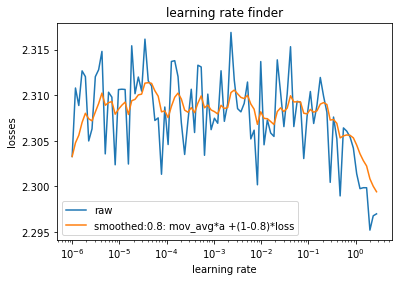

(None, None)

In [8]:
learn.find_subcription_by_cls(LR_Finder).plot_loss(0,5),plt.show()
#learn.find_subcription_by_cls(LR_Finder).plot_lr()

In [9]:
#Training: create model again because current LRFInd does not restore settings in model and opt
mm    = ModelManager( get_cnn_model(layers_sizes, data.c_in, data.c_out, layer=layer ) )
learn = Learner( mm.model, data, loss_func)
cbfs  = cbfs_base.copy()+[Recorder, partial(AvgStatsCallback,[accuracy])]
%time learn.fit(4,opt=SGD(sched,max_lr=0.5, max_wd=1e-3), cb_funcs=cbfs)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.302333,0.108840,2.294040,0.106400,00:02
1,1.773071,0.383980,0.575043,0.808100,00:02
2,0.401980,0.880600,0.220073,0.936200,00:02
3,0.217167,0.935460,0.173972,0.949500,00:02


CPU times: user 1min, sys: 9.59 s, total: 1min 10s
Wall time: 10.3 s


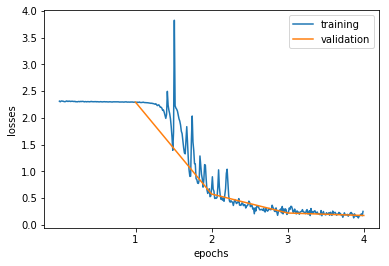

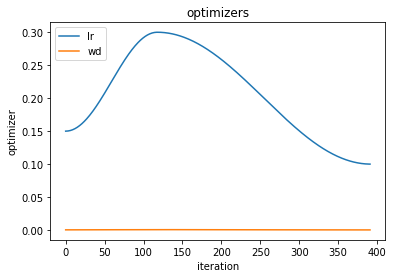

tensor(0.1684)

In [10]:
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.loss

## mnist with hooks

In [11]:
sched     = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)]) 
cbfs_base = [TrainableModelCallback, TrainEvalCallback, OptimizerCallback,
             partial(BatchTransformXCallback, tfm = mnist_view), ProgressCallback ]

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.302294,0.106520,2.297576,0.106400,00:03
1,1.986230,0.317980,0.782912,0.757900,00:03
2,0.424332,0.866160,0.188007,0.944200,00:03
3,0.174889,0.947320,0.144187,0.955900,00:03


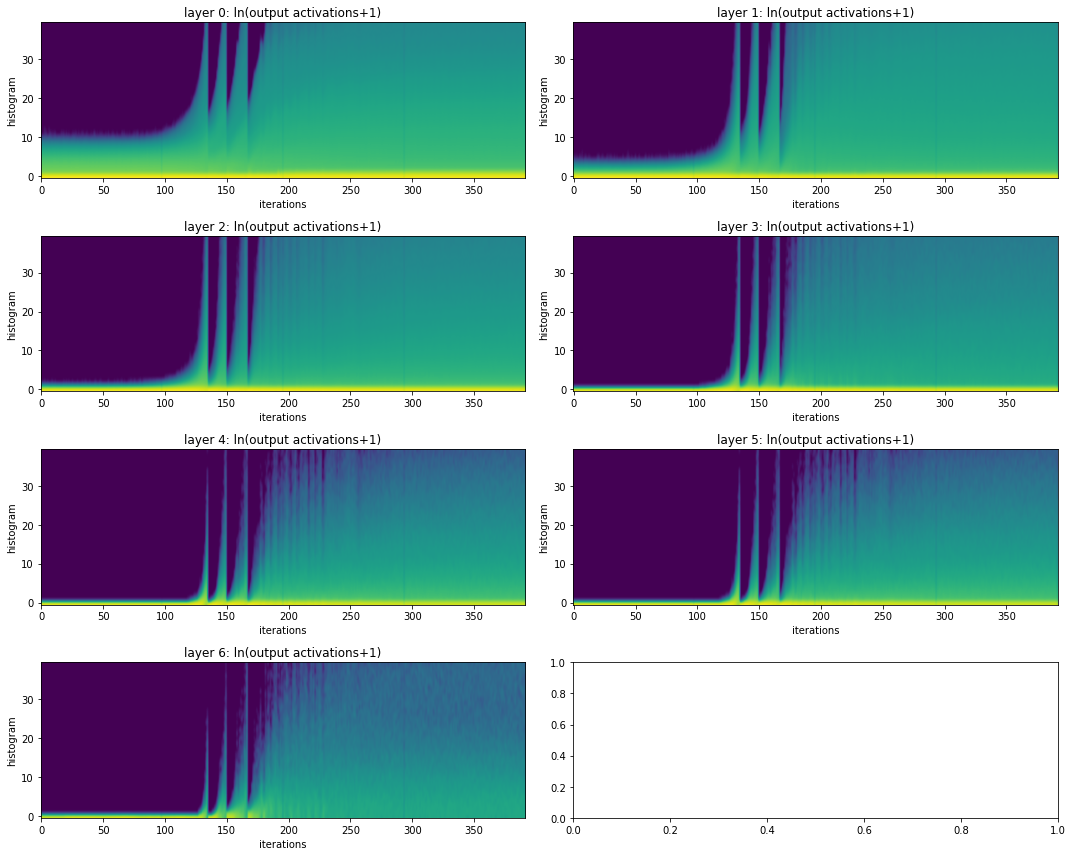

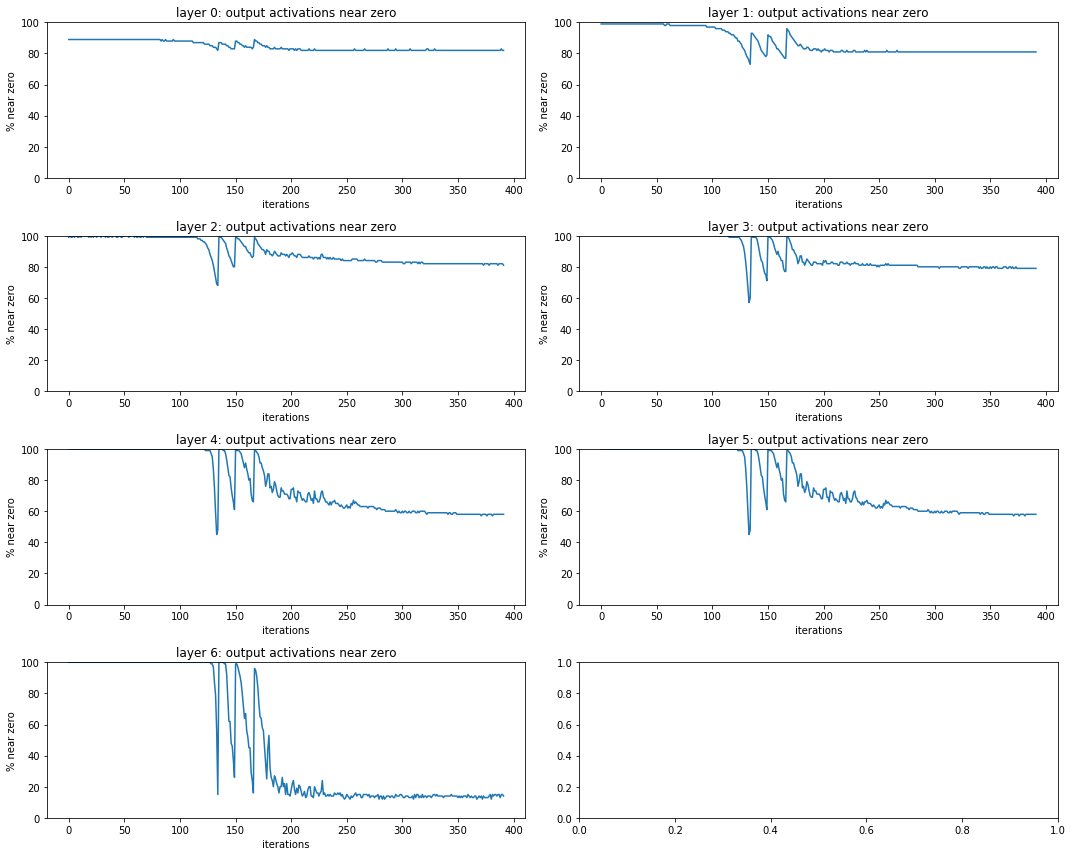

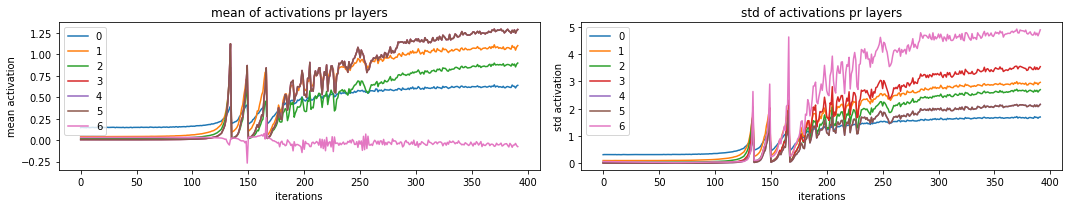

In [12]:
mm = ModelManager( get_cnn_model(layers_sizes, data.c_in, data.c_out, layer=layer ) )
with Hooks(mm.model, append_stats) as hooks: 
    learn = Learner( mm.model, data, loss_func)
    cbfs  = cbfs_base.copy() + [Recorder, partial(AvgStatsCallback,[accuracy]) ] 
    learn.fit(4, opt=SGD(sched,max_lr=0.5, max_wd=1e-3), cb_funcs=cbfs)
    plot_layer_stats( hooks )

## mnist with hooks and kaiming initialization

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.047075,0.671740,0.546911,0.798100,00:03
1,0.315996,0.903820,0.162454,0.949900,00:03
2,0.182891,0.945100,0.102328,0.970800,00:03
3,0.097796,0.971280,0.092560,0.973800,00:03


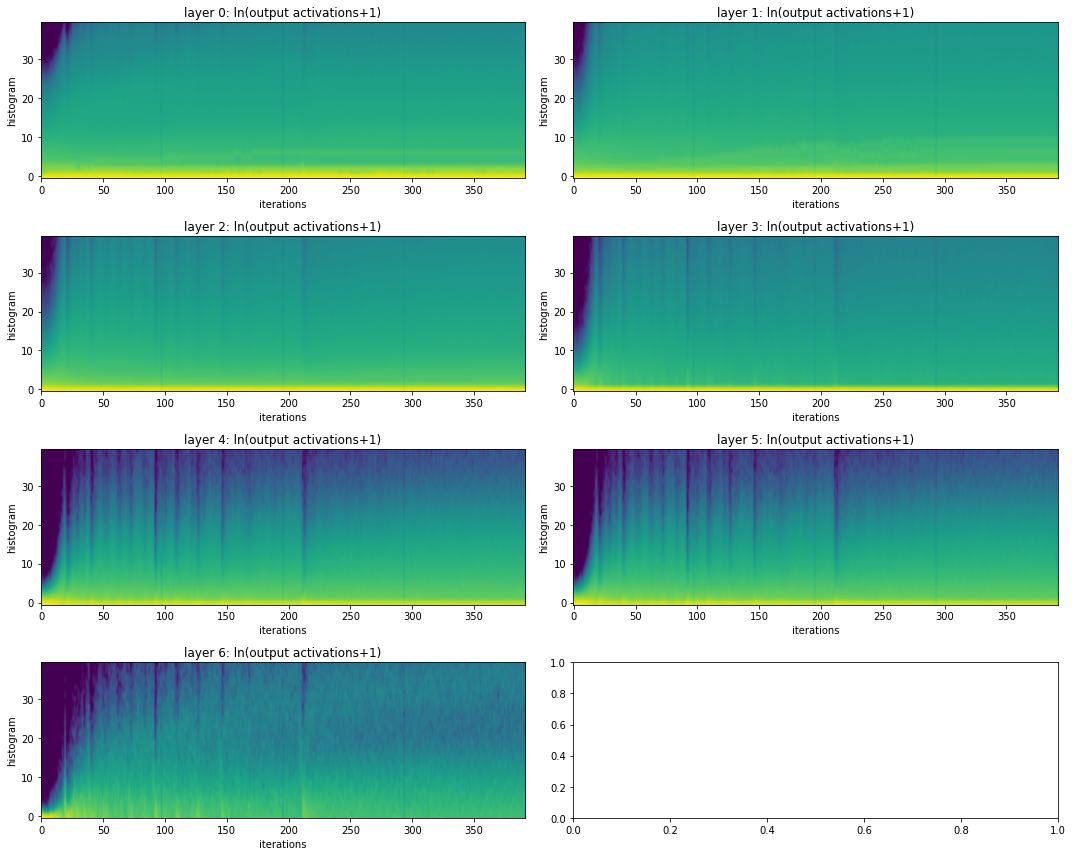

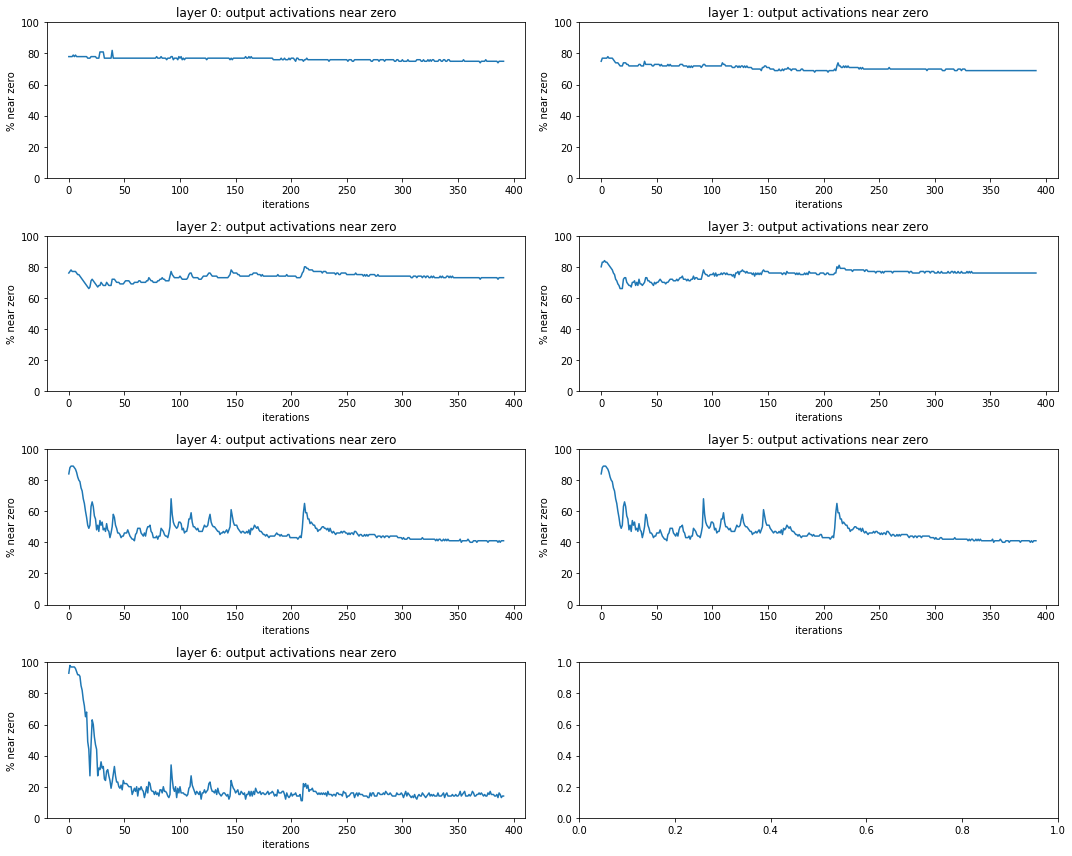

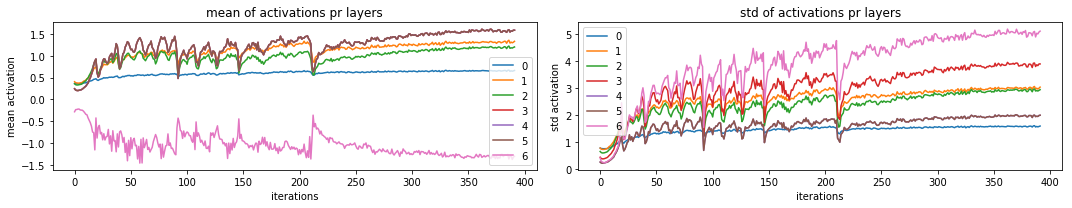

In [13]:
mm = CnnModelManager( get_cnn_model(layers_sizes, data.c_in, data.c_out, layer=layer ) )
mm.initialize(is_resnet=False)

with Hooks(mm.model, append_stats) as hooks: 
    learn = Learner( mm.model, data, loss_func)
    cbfs  = cbfs_base.copy() + [Recorder, partial(AvgStatsCallback,[accuracy]) ] 
    learn.fit(4, opt=SGD(sched,max_lr=0.5, max_wd=1e-3), cb_funcs=cbfs)
    plot_layer_stats( hooks )

## mnist with hooks + kaiming initialization + batchnorm

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.225862,0.672620,0.423477,0.903100,00:05
1,0.272232,0.930000,0.205300,0.945200,00:05
2,0.131413,0.964040,0.100586,0.973800,00:05
3,0.094550,0.974520,0.088217,0.976200,00:05


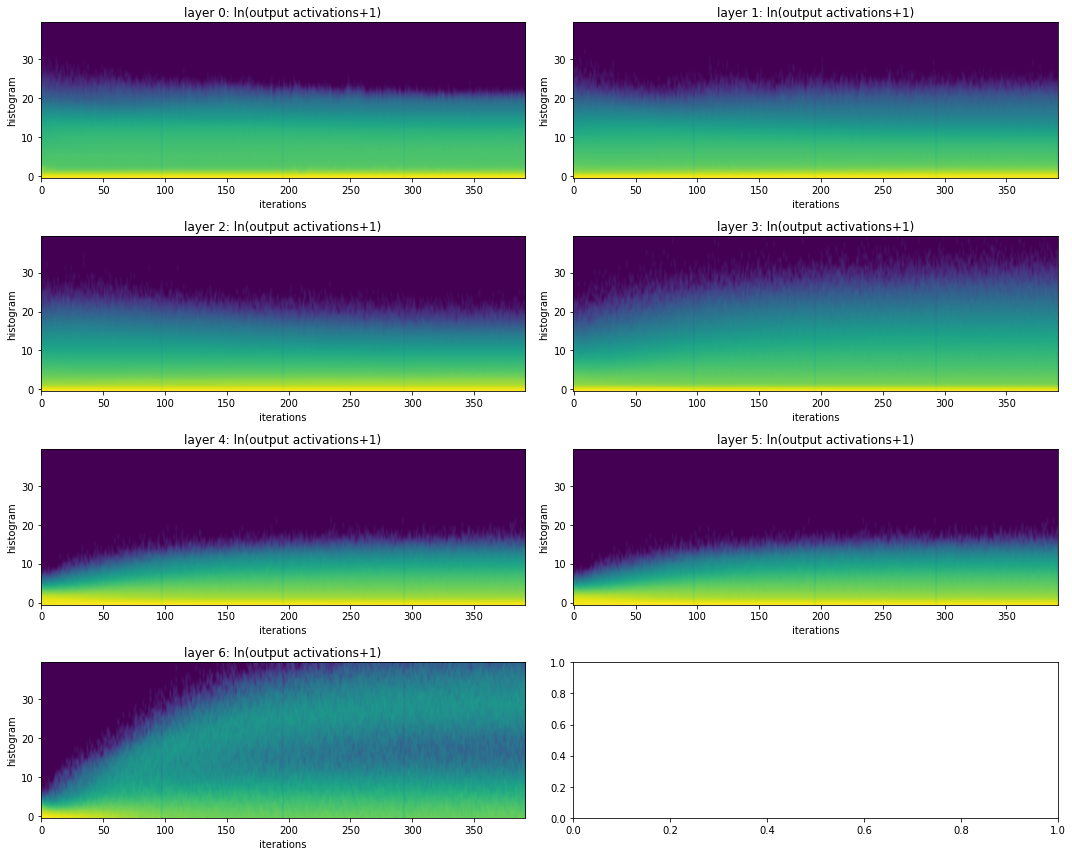

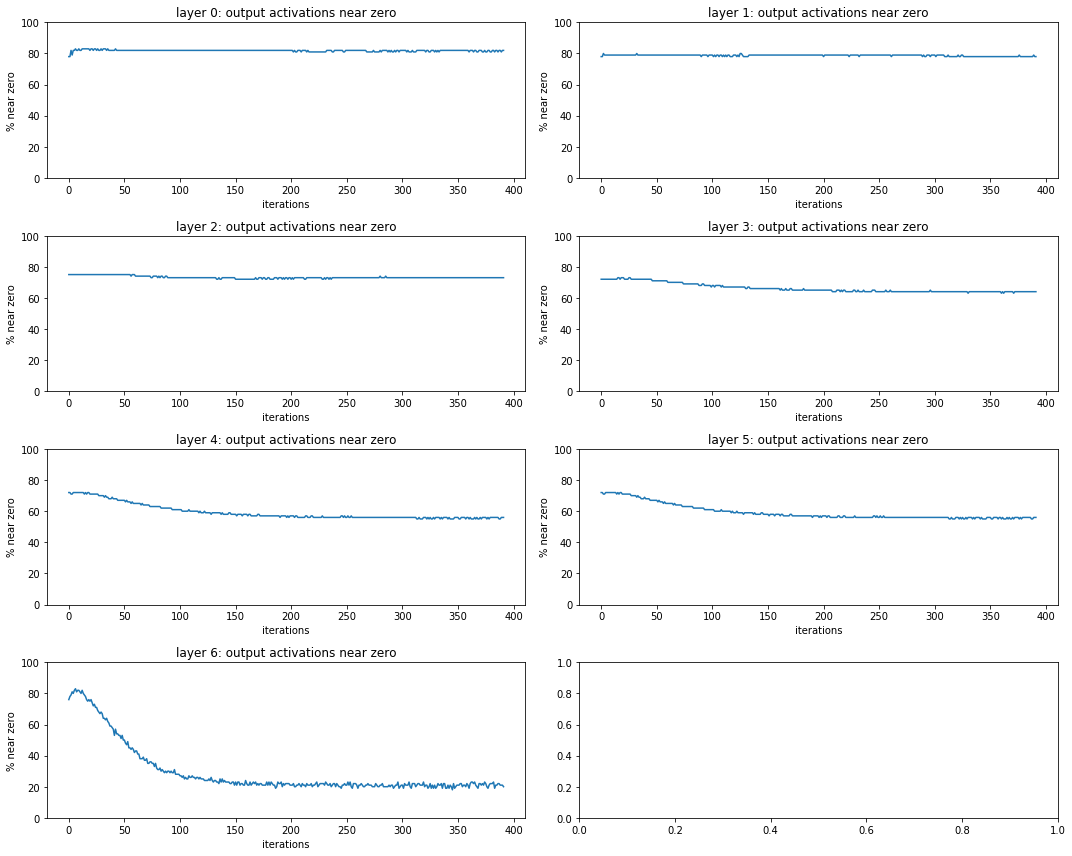

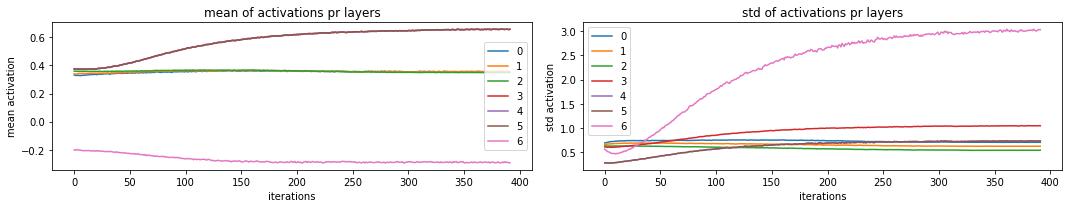

In [14]:
layer = partial( conv_layer, stride=2, bn=True, zero_bn=False, act=partial(torch.nn.ReLU,inplace=True) )
mm    = CnnModelManager( get_cnn_model(layers_sizes, data.c_in, data.c_out, layer=layer ) )
mm.initialize(is_resnet=False)

with Hooks(mm.model, append_stats) as hooks: 
    learn = Learner( mm.model, data, loss_func)
    cbfs  = cbfs_base.copy() + [Recorder, partial(AvgStatsCallback,[accuracy]) ] 
    learn.fit(4, opt=SGD(sched,max_lr=0.5, max_wd=1e-3), cb_funcs=cbfs)
    plot_layer_stats( hooks )